# Movie Weekend Trip Project

Movies are one of the nation's most popular pastimes. However, there are so many movies released that sometimes it can be a little overwhelming to figure out the next movie to watch! Thankfully, this is where **clustering** comes in. Using a clustering approach on a dataset of movie reviews and tags, we will be able to recommend similar movies to a given movie.

## Retrieving the Data
This data comes from the [MovieLens dataset](https://grouplens.org/datasets/movielens/) that aggregates movie reviews and tags for many films. The initial dataset comes with 6 files, but we will only be using the following datasets: `ratings.csv`, `movies.csv`, `genome-scores.csv`, and `genome-tags.csv`. We will not be using `tags.csv` because all the data we need from that dataset is already compiled into `genome-tags.csv`, and we will also not be using `links.csv`, as that data is not helpful for our purposes. We will begin by loading the dataset into a few dataframes:

In [1]:
from os import path
import numpy as np
import pandas as pd

ratings_df = pd.read_csv("data/raw/ratings.csv")
movies_df = pd.read_csv("data/raw/movies.csv")
g_scores_df = pd.read_csv("data/raw/genome-scores.csv")
g_tags_df = pd.read_csv("data/raw/genome-tags.csv")

Let's explore these datasets a little:

### ratings.csv
`ratings.csv` is a dataset of all ratings made for a movie. There are quite a bit:

In [2]:
print("Length: %d" % ratings_df.shape[0])
ratings_df.head()

Length: 20000263


,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


The keys for all of these data sets will be very simple:

|Key       |Description|
|:---------|:----------|
|userId    |ID of user leaving the review|
|movieId   |ID of the movie the review is for|
|rating    |Rating (0-5) of the movie|
|timestamp |Timestamp of the review (we will ignore this feature)|

### movies.csv
`movies.csv` defines the movies that are refrenced in all other datasets.

In [3]:
print("We have %d movies in our datasets" % movies_df.shape[0])
movies_df.head()

We have 27278 movies in our datasets


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


|Key     |Description|
|:-------|:----------|
|movieId |ID of the movie|
|title   |Title string of the movie|
|genre   |Genres ('\|' deliminated) of the movie|

### genome-scores.csv
`genome-scores.csv` will be very useful to us, as it explains how relevant a certain tag is to a certain movie. It has been precomputed for us using the `tags.csv` dataset.

In [4]:
g_scores_df.head()

,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


|Key       |Description|
|:---------|:----------|
|movieId   |ID of the movie|
|tagId     |Tag referring to the movie|
|relevance |How relevant that tag is to the movie, based on the data in `tags.csv`|

### genome-tags.csv
`genome-tags.csv` is simply the translator for `tagId` to what the tag actually is:

In [5]:
print("We have %d tags" % g_tags_df.shape[0])
g_tags_df.head()

We have 1128 tags


,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


|Key   |Description|
|:-----|:----------|
|tagId |ID of the tag|
|tag   |Name of the tag|

## Feature Engineering
In order to determine what movies go well with what other movies, we must define two rules:

A movie is similar to another movie if they
1. Both have a similar rating and
2. Both have similar tags

It would be valid to make it so that we only recommend better movies than the one requested, but if I'm in the mood for another bad movie, I should get another bad movie. So we will recommend only movies that are of similar quality to the one being requested.

### Similar Rating
In order to keep track of what movies have what rating, let's aggregate `ratings.csv` into the `movies.csv` dataset that keeps track of all movies and their average rating. Because this is a large dataset, we will precompute it and save the results:

In [6]:
# Check if we have already processed the data:
if not path.exists("data/processed/movies_processed.csv"):

    # If not, group movies by their ID and calculate their average rating
    avg_movie_rating = pd.DataFrame(ratings_df.groupby("movieId").apply(lambda row: np.average(row["rating"])),
                                    columns=["avgMovieRating"])

    # Then, calculate how many ratings there are for each movie
    num_movie_rating = pd.DataFrame(ratings_df[["movieId", "userId"]].groupby("movieId").agg("count"))\
                            .rename({"userId": "numMovieRatings"}, axis=1)
    avg_ratings_df = avg_movie_rating.merge(num_movie_rating, left_index=True, right_index=True)

    movies_df = movies_df.merge(avg_ratings_df, left_on="movieId", right_index=True)

    # Save the processed data to a csv file
    movies_df.to_csv("data/processed/movies_processed.csv")

# If we have already processed the data, retrieve it from the file
else:
    movies_df = pd.read_csv("data/processed/movies_processed.csv")
    movies_df.drop(movies_df.columns[0], axis=1, inplace=True) # Get rid of index column

movies_df.head()

,movieId,title,genres,avgMovieRating,numMovieRatings
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.921240,49695
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.211977,22243
2,3,Grumpier Old Men (1995),Comedy|Romance,3.151040,12735
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.861393,2756
4,5,Father of the Bride Part II (1995),Comedy,3.064592,12161


### Tags
All of the movies listed should have tags associated with them. Because I do not want to add all **1128** tags and their respective relevancy to the movie dataframe (adding 1128 columns, yeesh!) I will instead simply reference the `g_scores_df` dataframe and use a relevency factor (more information later) to compare movies.

## Data Filtering
We only care about the movies that are included in the `genome-scores.csv` dataset, so let's get rid of any movie that is not in that dataset:

In [7]:
# Get all valid movie IDs
valid_ids = np.intersect1d(movies_df["movieId"].unique(), g_scores_df["movieId"].unique())

movies_df = movies_df[np.isin(movies_df["movieId"], valid_ids)]
g_scores_df = g_scores_df[np.isin(g_scores_df["movieId"], valid_ids)]

## Analysis
Let's analyze some movie relationships! Let's do this by visualizing how movies are similar to one another, and then using clustering to group them up. The way we will do this will be specifying similar movies by `tags`, as we will see soon. First, let's pick a movie to test it on:

In [8]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

# The Blues Brothers is my favorite movie, so we'll use that as our test
test_movie = movies_df.loc[movies_df["title"].str.contains("Blues Brothers, The")]
test_movie_id = test_movie["movieId"].values[0]
test_movie_title = test_movie["title"].values[0]
test_movie_rating = test_movie["avgMovieRating"].values[0]

### Specify by Tag
We can use specific tags and their relevance to movies as a way to find relationships between movies. To do this, we must first find what tags are most representative of the movie we are looking for. For this, we will get the top 3 most relevant tags:

In [9]:
most_relevant_tags = g_scores_df[g_scores_df["movieId"] == test_movie_id]\
                        .sort_values(by=["relevance"], ascending=False)\
                        .take([0, 1, 2])
most_relevant_tag_ids = most_relevant_tags["tagId"].values

for i in range(3):
    print("%d: %s" % (i, g_tags_df["tag"][g_tags_df["tagId"] == most_relevant_tag_ids[i]].values[0]))

0: music
1: musicians
2: chase


Now we can use these 3 tags to find similar movies. Let's start by creating a `Relevance Factor`, or a number (with a max value of 3) that tells how alike a movie is to the test movie according to the relevancy of its tags. Because this takes a very long time, we will save the processed file in a csv file:

In [10]:
test_movie_df = pd.DataFrame(movies_df)

# Check if we have already processed the data:
if not path.exists("data/processed/test_movie_dataset.csv"):

    def get_relevance_factor(row):
        movie_id = row["movieId"]
        g_tags_movie = g_scores_df.loc[g_scores_df["movieId"] == movie_id]
        return sum(g_tags_movie.loc[g_tags_movie["tagId"].isin(most_relevant_tag_ids), "relevance"])

    # If not, run the relevance factor function on the dataset
    test_movie_df["relevanceFactor"] = test_movie_df.apply(get_relevance_factor, axis=1)

    # Save the processed data to a csv file
    test_movie_df.to_csv("data/processed/test_movie_dataset.csv")

# If we have already processed the data, retrieve it from the file
else:
    test_movie_df = pd.read_csv("data/processed/test_movie_dataset.csv")
    test_movie_df.drop(test_movie_df.columns[0], axis=1, inplace=True) # Get rid of index column

test_movie_df.head()

,movieId,title,genres,avgMovieRating,numMovieRatings,relevanceFactor
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.921240,49695,0.66350
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.211977,22243,0.68325
2,3,Grumpier Old Men (1995),Comedy|Romance,3.151040,12735,0.58400
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.861393,2756,0.36725
4,5,Father of the Bride Part II (1995),Comedy,3.064592,12161,0.62250


Let's define some data that we can use for the rest of the analysis:

In [11]:
relevance_by_movie = pd.Series(test_movie_df["relevanceFactor"].values, index=test_movie_df["movieId"])
rating_by_movie = pd.Series(test_movie_df["avgMovieRating"].values, index=test_movie_df["movieId"])

data = np.array(list(zip(rating_by_movie.values, relevance_by_movie.values, rating_by_movie.index)))
# To clean up the data, let's get rid of anything that has a relevance factor of 1 or less
data = np.array(list(filter(lambda d: d[1] > 1, data)))

test_movie_data_index = np.where(data[:, 2] == test_movie_id)[0][0]
test_movie_relevency_factor = data[test_movie_data_index, 1]

Let's go ahead and take a look at what our data looks like:

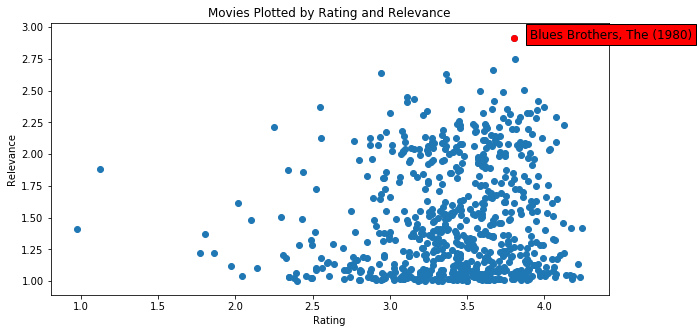

In [12]:
plt.figure(figsize=(10, 5))

plt.scatter(data[:, 0], data[:, 1])
plt.title("Movies Plotted by Rating and Relevance")
plt.xlabel("Rating")
plt.ylabel("Relevance")

plt.scatter(test_movie_rating, test_movie_relevency_factor, c='r')
plt.text(test_movie_rating + 0.1, test_movie_relevency_factor, test_movie_title, fontsize=12, bbox=dict(facecolor='red'))

plt.show()

Once we have this graph, we can use clustering to break up the data:

#### K-Means

In [13]:
# 10 seems like a good amount of clusters
#   there's not too many so as to give us very few data points in each cluster,
#   but there's still enough to keep the cluster sizes small and useful
num_clusters = 10

# Compute the k-means clustering
kmeans = KMeans(n_clusters=num_clusters).fit(data[:, :2])
labels = kmeans.labels_

# Get similar movies
test_movie_cluster = labels[test_movie_data_index]
similar_movies_indices = np.where(labels == test_movie_cluster)
similar_movies_ids = data[similar_movies_indices][:, 2]
kmeans_similar_movies = test_movie_df[test_movie_df["movieId"].isin(similar_movies_ids)]\
    .sort_values(by=["relevanceFactor"], ascending=False)
kmeans_similar_movies = kmeans_similar_movies.drop(kmeans_similar_movies.index[0]) # Drop our test movie

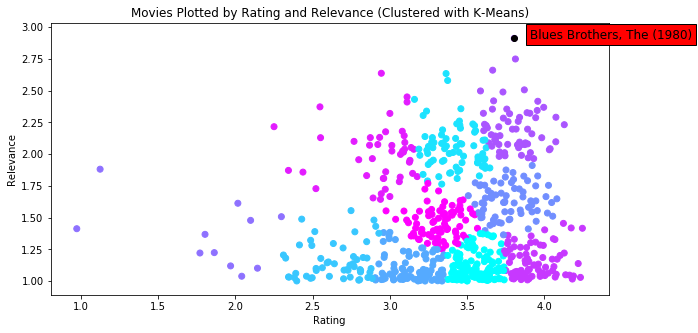

In [14]:
plt.figure(figsize=(10, 5))
plt.cool()

plt.scatter(data[:, 0], data[:, 1], c=labels)

plt.title("Movies Plotted by Rating and Relevance (Clustered with K-Means)")
plt.xlabel("Rating")
plt.ylabel("Relevance")

plt.scatter(test_movie_rating, test_movie_relevency_factor, c='k')
plt.text(test_movie_rating + 0.1, test_movie_relevency_factor, test_movie_title, fontsize=12, bbox=dict(facecolor='red'))

plt.show()

#### Hierarchical Agglomerative Clustering

In [15]:
agg_clustering = AgglomerativeClustering(n_clusters=num_clusters).fit(data[:, :2])
labels = agg_clustering.labels_

test_movie_cluster = labels[test_movie_data_index]
similar_movies_indices = np.where(labels == test_movie_cluster)
similar_movies_ids = data[similar_movies_indices][:, 2]
agg_similar_movies = test_movie_df[test_movie_df["movieId"].isin(similar_movies_ids)]\
    .sort_values(by=["relevanceFactor"], ascending=False)
agg_similar_movies = agg_similar_movies.drop(agg_similar_movies.index[0]) # Drop our test movie

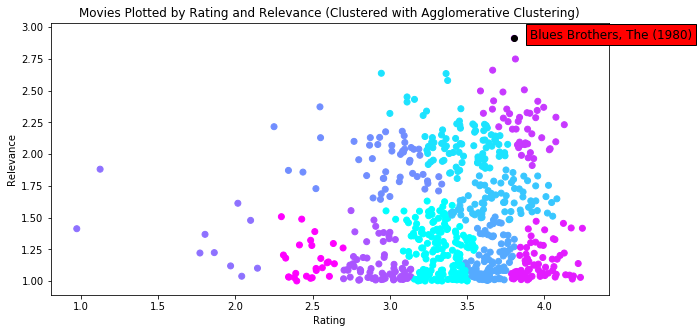

In [16]:
plt.figure(figsize=(10, 5))

plt.scatter(data[:, 0], data[:, 1], c=agg_clustering.labels_)

plt.title("Movies Plotted by Rating and Relevance (Clustered with Agglomerative Clustering)")
plt.xlabel("Rating")
plt.ylabel("Relevance")

plt.scatter(test_movie_rating, test_movie_relevency_factor, c='k')
plt.text(test_movie_rating + 0.1, test_movie_relevency_factor, test_movie_title, fontsize=12, bbox=dict(facecolor='red'))

plt.show()

### What Should I Watch?
Moment of truth, let's check out some similar movies:

In [17]:
kmeans_similar_movies.head()

,movieId,title,genres,avgMovieRating,numMovieRatings,relevanceFactor
9782,101106,Sound City (2013),Documentary,3.812500,72,2.75025
4277,4824,Grateful Dawg (2000),Documentary,3.665217,115,2.66200
5058,5820,Standing in the Shadows of Motown (2002),Documentary|Musical,3.870253,474,2.50700
7790,46347,Metal: A Headbanger's Journey (2005),Documentary,3.586345,249,2.49850
60,62,Mr. Holland's Opus (1995),Drama,3.731825,19381,2.49000


In [18]:
agg_similar_movies.head()

,movieId,title,genres,avgMovieRating,numMovieRatings,relevanceFactor
9782,101106,Sound City (2013),Documentary,3.812500,72,2.75025
4277,4824,Grateful Dawg (2000),Documentary,3.665217,115,2.66200
5058,5820,Standing in the Shadows of Motown (2002),Documentary|Musical,3.870253,474,2.50700
7790,46347,Metal: A Headbanger's Journey (2005),Documentary,3.586345,249,2.49850
60,62,Mr. Holland's Opus (1995),Drama,3.731825,19381,2.49000


It seems that both of our methods recommend a few different movies. It is important to not that all 5 of these movies all have something to do with `music` and `musicians`, 2 of the 3 tags we searched for. It is interesting how most of the recommended movies are `Documentaries`, unlike our test movie which is a `Comedy`. This is something that could be expanded on in subsequent research.

## Conclusion
After clustering movies together using a ratings and tags approach, we were able to generate a list of movies that are similar in content to the movie that we tested on. The two approaches I used were **K-Means** and **Hierarchical Agglomerative Clustering**. I used K-Means because it was simple and fast, and I used HAC because it has a higher success rate than K-Means. I chose both of them for the main reason that I would be able to seperate the data into a set number of clusters. I did this to make sure that the cluster sizes weren't too big that movies caught in the cluster would not be similar to the test movie, but also too small to not be helpful. In the end, I believe that our list was sufficient, and with a result of around _70_ movies, there is plenty to watch.

### What Next?
Where could we go from here? An easy thing we could do is update our relevancy factor calculation function to take into account other factors, such as `genre`. A challenge there would be balancing the importance of `tags` vs `genre`. Speaking of tags, another thing we could do is increase the amount of tags used to calculate the relevance factor. In this solution, I used _3_, but the function could easily be expanded to take in all of the tags, if you don't mind waiting a few hours for the computer to calculate all of the movies' relevancies. Another useful thing to do would be to take into account how many reviews were placed for a given movie. This is a good indicator of popularity as well as would add credibility to the `average movie rating`.